In [1]:
import string

import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

import nltk
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('vader_lexicon')

from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shrutirao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shrutirao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/shrutirao/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df = pd.read_csv('data/employees_cleaned_data.csv', index_col=0)

In [4]:
df

,floor,ground-floor - Selected Choice,ground-floor - Others - Text,emotion,comfort
1,5th Floor,Shared room,NaN,"Good, there could be more plants",Stores come down without us wanting that. That...
2,4th Floor,Shared room,NaN,Positive and focused,Slightly annoyed by the artificial light and t...
3,4th Floor,Shared room,NaN,Happy,Very
4,5th Floor,Private room,NaN,Sunny and happy and colorful,Love it
5,6th Floor,Shared room,NaN,'this space' is ambiguous. If you mean the bui...,"I feel comfortable because of the lighting, sp..."
6,5th Floor,Shared room,NaN,"A mix of 'isolated', 'open', 'collaborative'",Temperature was a bit low for my comfort earli...
7,4th Floor,Shared room,NaN,"Calm, happy, comfortable",Strongly comfortable. I have a good connectio...
8,5th Floor,Shared room,NaN,NaN,NaN
9,5th Floor,Shared room,NaN,"the office in which I work is dark, and gives ...",NaN
10,6th Floor,Shared room,NaN,NaN,NaN


In [5]:
df.columns

Index(['floor', 'ground-floor - Selected Choice',
       'ground-floor - Others - Text', 'emotion', 'comfort'],
      dtype='object')

In [3]:
df.describe()

,ground-floor - Others - Text
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [6]:
df = df.rename(columns={"ground-floor - Selected Choice": "space-type",
                        "ground-floor - Others - Text": "space-type-others"})

In [7]:
df

,floor,space-type,space-type-others,emotion,comfort
1,5th Floor,Shared room,NaN,"Good, there could be more plants",Stores come down without us wanting that. That...
2,4th Floor,Shared room,NaN,Positive and focused,Slightly annoyed by the artificial light and t...
3,4th Floor,Shared room,NaN,Happy,Very
4,5th Floor,Private room,NaN,Sunny and happy and colorful,Love it
5,6th Floor,Shared room,NaN,'this space' is ambiguous. If you mean the bui...,"I feel comfortable because of the lighting, sp..."
6,5th Floor,Shared room,NaN,"A mix of 'isolated', 'open', 'collaborative'",Temperature was a bit low for my comfort earli...
7,4th Floor,Shared room,NaN,"Calm, happy, comfortable",Strongly comfortable. I have a good connectio...
8,5th Floor,Shared room,NaN,NaN,NaN
9,5th Floor,Shared room,NaN,"the office in which I work is dark, and gives ...",NaN
10,6th Floor,Shared room,NaN,NaN,NaN


# Responses Across the Building 904

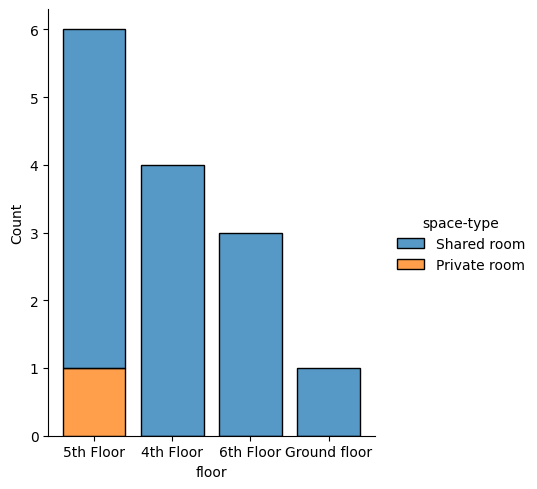

In [10]:
# fig, ax = plt.subplots()
sns.displot(df, x="floor",
            hue="space-type",
            multiple="stack",
            height=5,
            aspect=0.8,
            shrink=.8)
# fig.set_size_inches(8, 5)
plt.savefig('plots/employees-floors-responses.jpg', dpi=300, bbox_inches="tight")

# Emotions

In [11]:
df

,floor,space-type,space-type-others,emotion,comfort
1,5th Floor,Shared room,NaN,"Good, there could be more plants",Stores come down without us wanting that. That...
2,4th Floor,Shared room,NaN,Positive and focused,Slightly annoyed by the artificial light and t...
3,4th Floor,Shared room,NaN,Happy,Very
4,5th Floor,Private room,NaN,Sunny and happy and colorful,Love it
5,6th Floor,Shared room,NaN,'this space' is ambiguous. If you mean the bui...,"I feel comfortable because of the lighting, sp..."
6,5th Floor,Shared room,NaN,"A mix of 'isolated', 'open', 'collaborative'",Temperature was a bit low for my comfort earli...
7,4th Floor,Shared room,NaN,"Calm, happy, comfortable",Strongly comfortable. I have a good connectio...
8,5th Floor,Shared room,NaN,NaN,NaN
9,5th Floor,Shared room,NaN,"the office in which I work is dark, and gives ...",NaN
10,6th Floor,Shared room,NaN,NaN,NaN


In [67]:
df_emo = df.emotion.dropna()
df_emo = df_emo.apply(lambda x: x.replace('’', ''))
df_emo = df_emo.apply(lambda x: x.replace("'", ''))
df_emo = df_emo.apply(lambda x: x.replace('`', ''))

### Tokenise

In [68]:
df_emo

1                      Good, there could be more plants
2                                  Positive and focused
3                                                 Happy
4                         Sunny and happy and colorful 
5     this space is ambiguous. If you mean the build...
6               A mix of isolated,  open, collaborative
7                              Calm, happy, comfortable
9     the office in which I work is dark, and gives ...
12    I feel anxious a lot of the time but that is a...
Name: emotion, dtype: object

In [69]:
import string

def apply_token(row):
    stop_words = set(stopwords.words("english"))
    words_in_sent = word_tokenize(row)

    filtered_list = []
    
    for word in words_in_sent:
        if word.casefold() not in stop_words:
            filtered_list.append(word)
    
    return filtered_list

In [70]:
df_emo = df_emo.apply(apply_token)

In [76]:
for row in df_emo:
    print(row)

['Good', ',', 'could', 'plants']
['Positive', 'focused']
['Happy']
['Sunny', 'happy', 'colorful']
['space', 'ambiguous', '.', 'mean', 'building', ':', 'feels', 'comfortable', 'light', 'lots', 'green', 'spacious', '.']
['mix', 'isolated', ',', 'open', ',', 'collaborative']
['Calm', ',', 'happy', ',', 'comfortable']
['office', 'work', 'dark', ',', 'gives', 'artificial', 'impression', '.', 'light', 'enters', 'main', 'ceiling', 'central', 'court', 'moments', 'day', '.', 'although', 'artificial', 'light', 'strong', ',', 'feel', 'lack', 'real', '``', 'horizon', "''", 'room', ',', 'giving', 'sensation', 'imprisonment', ',', 'somehow', 'loneliness', '.', 'window', ',', 'gives', 'unnatural', 'feeling', 'respect', 'air', '.', 'plants', 'common', 'room', 'plastic', '(', 'discovering', 'even', 'angrier', '``', 'sustainability', "''", 'claims', 'entoured', 'building', ')', '.', 'ceiling', 'common', 'room', 'corridor', 'black/very', 'dark', 'low', 'height', '.', 'carpets', 'convey', 'sensations', 'd

In [102]:
def cleanup(df_emo):
    combo_emo = []
    for row in df_emo:
        combo_emo.append(row)
    
    combo_emo = list(np.concatenate(combo_emo).flat)
    combo_emo = list(filter(lambda token: token not in string.punctuation,
                            combo_emo))
    combo_emo = list(filter(lambda token: len(token) > 2 ,
                            combo_emo))
    combo_emo = [x.lower() for x in combo_emo]
    
    return combo_emo

In [103]:
len('``')

2

In [104]:
combo_emo_list = cleanup(df_emo)

In [105]:
frequency_distribution = FreqDist(combo_emo_list)
frequency_distribution.most_common(20)

[('happy', 3),
 ('light', 3),
 ('artificial', 3),
 ('feel', 3),
 ('room', 3),
 ('plants', 2),
 ('building', 2),
 ('comfortable', 2),
 ('open', 2),
 ('dark', 2),
 ('gives', 2),
 ('ceiling', 2),
 ('day', 2),
 ('common', 2),
 ('sensations', 2),
 ('spaces', 2),
 ('also', 2),
 ('good', 1),
 ('could', 1),
 ('positive', 1)]

In [116]:
def frequency_distribution(lst, label):
    top_n = FreqDist(lst).most_common(20)
    frequency_distribution = pd.Series(dict(top_n))

    sns.set_theme(style="ticks")
    sns.barplot(y=frequency_distribution.index,
                x=frequency_distribution.values,
                palette = 'hls',
                saturation = 8)
    plt.xlabel("Count of responses")
    plt.ylabel("Most frequently occuring responses")
    plt.gcf().set_size_inches(5,7)
    # plt.xlim(0,20)

    plt.savefig('plots/employees-' + label + '-freq-dist.jpg',
            dpi=300, bbox_inches='tight')

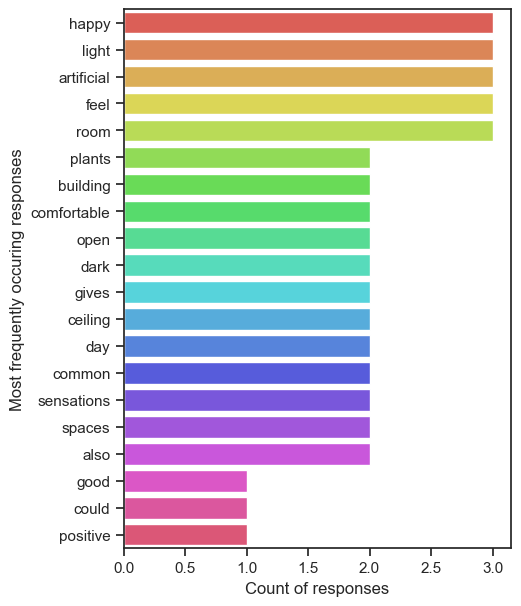

In [107]:
frequency_distribution(combo_emo_list, 'emo')

calm (19), bit (6), nice (5), feel (4), quiet (4), neutral (4), relaxed (4), focused (4), noisy (3), cold (3), stressed (3), happy (3), motivated (3), peaceful (3), tired (3), good (3), study (3), building (3)

Interesting to note that words associated with emotion questions also included some words about comfort such as `cold` and `noisy`. Overall, we see that words associated with emotions are a mix of emotions, moods, sentiments, that are also typically associated with learning (`stressed`, `focused`, `motivated`)

### Lemmatisation

In [108]:
def lemmatiser(labels):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in labels]
    return lemmatized_words

def check_collocations(lst):
    return nltk.Text(lst).collocations()
    
def find_collocations(df_emo):
    lem_emo = df_emo.apply(lemmatiser)
    combined_emos = list(np.concatenate(lem_emo.to_list()).flat)
    return check_collocations(combined_emos)

In [109]:
find_collocations(df_emo)

common room


study calm were the most frequently occuring pair of words (collocations) in the list of emotions.

# Comfort

In [110]:
df_comfort = df.comfort.dropna()
df_comfort = df_comfort.apply(lambda x: x.replace('’', ''))

### Tokenise

In [111]:
df_comfort = df_comfort.apply(apply_token)
combo_comfort_list = cleanup(df_comfort)

In [112]:
combo_comfort_list = [word for word in combo_comfort_list if word != "'s"]

In [113]:
frequency_distribution = FreqDist(combo_comfort_list)
frequency_distribution.most_common(20)

[('good', 3),
 ('light', 3),
 ('also', 2),
 ('could', 2),
 ('comfortable', 2),
 ('lighting', 2),
 ('space', 2),
 ('bit', 2),
 ('office', 2),
 ('room', 2),
 ('think', 2),
 ('stores', 1),
 ('come', 1),
 ('without', 1),
 ('wanting', 1),
 ('thats', 1),
 ('uncomfortable', 1),
 ('small', 1),
 ('flies', 1),
 ('pretty', 1)]

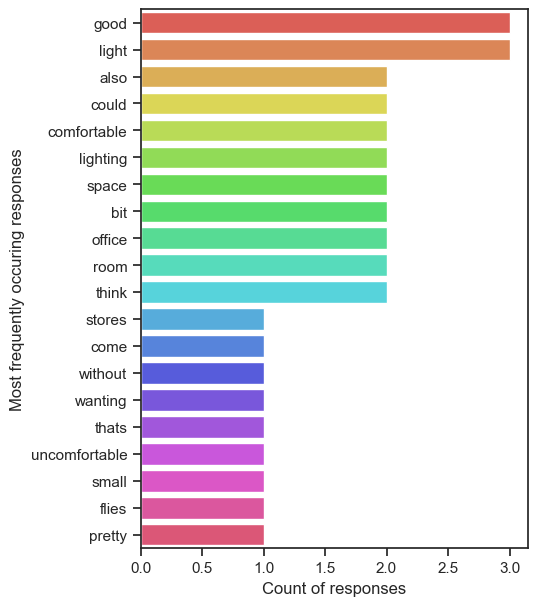

In [117]:
frequency_distribution(combo_comfort_list, 'comfort')

'comfortable' (23), 'light'(12), 'cold' (10), 'good' (10), 'noise' (9), 'temperature' (8), 'air' (8), 'nice' (8), 'room' (7), ('pretty', 7), ('space', 5), ('quality', 5), ('window', 5), ('fine', 5), ('like', 5), ('noisy', 5), ('little', 5), ('well', 4), ('lighting', 4), ('warm', 4), ('lot', 4), ('make', 4), ('feel', 4), ('blinds', 4), ('dark', 4), ('natural', 4), ('ok', 4), ('perfect', 3)

Most focus on light and temperature followed by noise. People also noted overall space and comfort as a whole. 

### Lemmatisation

In [118]:
find_collocations(df_comfort)

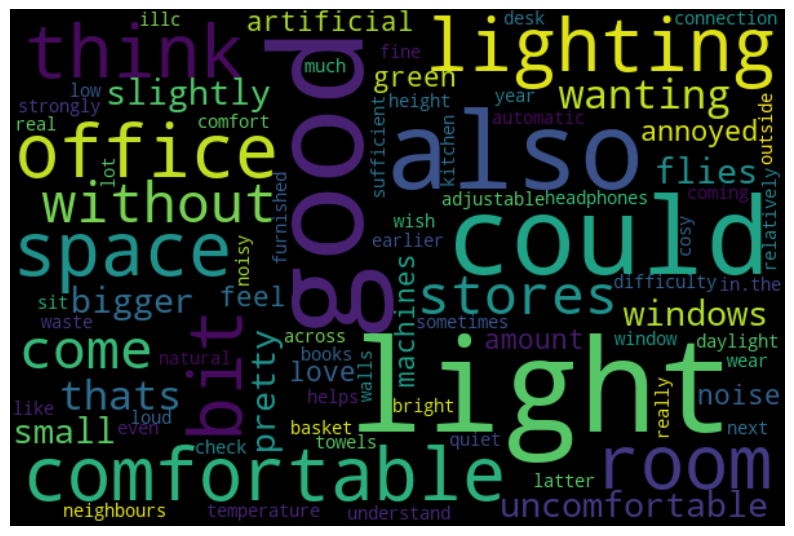

In [119]:
from collections import Counter
combo_comfort_cloud=Counter(combo_comfort_list)

wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100).generate_from_frequencies(combo_comfort_cloud)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

# Sentiment Analysis

In [120]:
def sentiment_analysis(df, label):
    analyzer = SentimentIntensityAnalyzer()
    df[label + '-polarity'] = df[label].apply(lambda x: analyzer.polarity_scores(str(x)))
    df = pd.concat([df, df[label + '-polarity'].apply(pd.Series)], axis=1)
    df[label + '-sentiment'] = df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')

    print("Most positive emotion statement: ", df.loc[df['compound'].idxmax()].values)
    print("\n")
    print("Most negative emotion statement: ", df.loc[df['compound'].idxmin()].values)
    
    return df 

In [121]:
def plot_sentiment_analysis(df, label):
    sns.countplot(y=label+'-sentiment', 
                  data=df,
                  palette=['#b2d8d8',"#008080", '#db3d13'])
    plt.ylabel("Sentiment for " + label + " Text")
    plt.xlabel("Count")
    # plt.xlim(0,45)
    plt.savefig('plots/employees-' + label + '-sentiment-count.jpg',
                dpi=300, bbox_inches='tight')
    
    plt.clf()
    
    sns.boxplot(x='floor', y='compound', data=df)
    plt.xlabel("Floor")
    plt.ylabel("Sentiment Value \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.tick_params(bottom=False)
    plt.axhline(0, ls='--', c = 'grey')
    plt.savefig('plots/employees}-' + label + '-sentiment-distribution.jpg',
                dpi=300, bbox_inches='tight')

In [47]:
df_sent_emo.sort_values(by="pos", ascending=False)

,floor,space-type,space-type-others,emotion,comfort,emotion-polarity,comfort-polarity,neg,neu,pos,compound,emotion-sentiment
3,4th Floor,Shared room,NaN,Happy,Very,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.000,1.000,0.5719,positive
7,4th Floor,Shared room,NaN,"Calm, happy, comfortable",Strongly comfortable. I have a good connectio...,"{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...","{'neg': 0.0, 'neu': 0.758, 'pos': 0.242, 'comp...",0.000,0.000,1.000,0.8519,positive
2,4th Floor,Shared room,NaN,Positive and focused,Slightly annoyed by the artificial light and t...,"{'neg': 0.0, 'neu': 0.139, 'pos': 0.861, 'comp...","{'neg': 0.187, 'neu': 0.813, 'pos': 0.0, 'comp...",0.000,0.139,0.861,0.7351,positive
4,5th Floor,Private room,NaN,Sunny and happy and colorful,Love it,"{'neg': 0.0, 'neu': 0.316, 'pos': 0.684, 'comp...","{'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'comp...",0.000,0.316,0.684,0.7579,positive
1,5th Floor,Shared room,NaN,"Good, there could be more plants",Stores come down without us wanting that. That...,"{'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'comp...","{'neg': 0.088, 'neu': 0.707, 'pos': 0.205, 'co...",0.000,0.633,0.367,0.4404,positive
5,6th Floor,Shared room,NaN,'this space' is ambiguous. If you mean the bui...,"I feel comfortable because of the lighting, sp...","{'neg': 0.0, 'neu': 0.875, 'pos': 0.125, 'comp...","{'neg': 0.0, 'neu': 0.752, 'pos': 0.248, 'comp...",0.000,0.875,0.125,0.5106,positive
12,5th Floor,Shared room,NaN,I feel anxious a lot of the time but that is a...,"THere is a lot of natural light, which is good...","{'neg': 0.136, 'neu': 0.749, 'pos': 0.116, 'co...","{'neg': 0.0, 'neu': 0.777, 'pos': 0.223, 'comp...",0.136,0.749,0.116,0.0989,positive
9,5th Floor,Shared room,NaN,"the office in which I work is dark, and gives ...",NaN,"{'neg': 0.044, 'neu': 0.861, 'pos': 0.095, 'co...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.044,0.861,0.095,0.8898,positive
6,5th Floor,Shared room,NaN,"A mix of 'isolated', 'open', 'collaborative'",Temperature was a bit low for my comfort earli...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.161, 'neu': 0.722, 'pos': 0.117, 'co...",0.000,1.000,0.000,0.0000,neutral
8,5th Floor,Shared room,NaN,NaN,NaN,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neutral


In [122]:
df_sent_emo = sentiment_analysis(df, 'emotion')

Most positive emotion statement:  ['5th Floor' 'Shared room' nan
 'the office in which I work is dark, and gives me an artificial impression. light enters through the main ceiling in the central court only a few moments in the day. although the artificial light is strong, I feel the lack of some real "horizon" from my room, giving the sensation of imprisonment, and somehow loneliness. there is no window, that gives an unnatural feeling with respect to air. the plants in the common room are of plastic (and by discovering this I was even angrier for the "sustainability" claims that has entoured the building). the ceiling of the common room and corridor is black/very dark and has a low height. the carpets convey sensations of dust. since my first day, I have sensations of beinng a mine (cognitive?) workers, or some apartment mouse.   research perhaps has some affinities with extraction, but I am emotionally engaged by seeing plenary rooms occupied freely by students studying and working, 

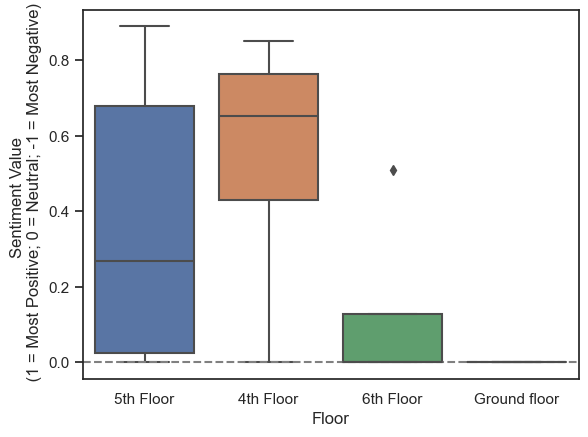

In [123]:
plot_sentiment_analysis(df_sent_emo, 'emotion')

### Emotion: `relaxed`

In [117]:
df_sent_emo[['floor','emotion', 'emotion-sentiment']][df_sent_emo['emotion'].str.contains("relaxed")==True]

,floor,emotion,emotion-sentiment
20,1st Floor,"Little cold, sort of relaxed",positive
38,1st Floor,Curious and relaxed,positive
50,1st Floor,"Bit distracted, relaxed, out in the open",positive
65,1st Floor,I feel relaxed. I’m here to do a bit of studyi...,positive
87,Ground floor,"concentrated, relaxed",positive
88,Ground floor,Nice and relaxed,positive
95,Ground floor,"Fine, relaxed,",positive
104,Ground floor,I feel motivated and also relaxed.,positive


In [120]:
for row in df_sent_emo['emotion'][df_sent_emo['emotion'].str.contains("calm")==True]:
    print(row)

Good, calm
Bright, open, happy, calm
Relaxt, calm
Open and calm 
Feeling anxious and stressed but the space is nice and helps to be more calm


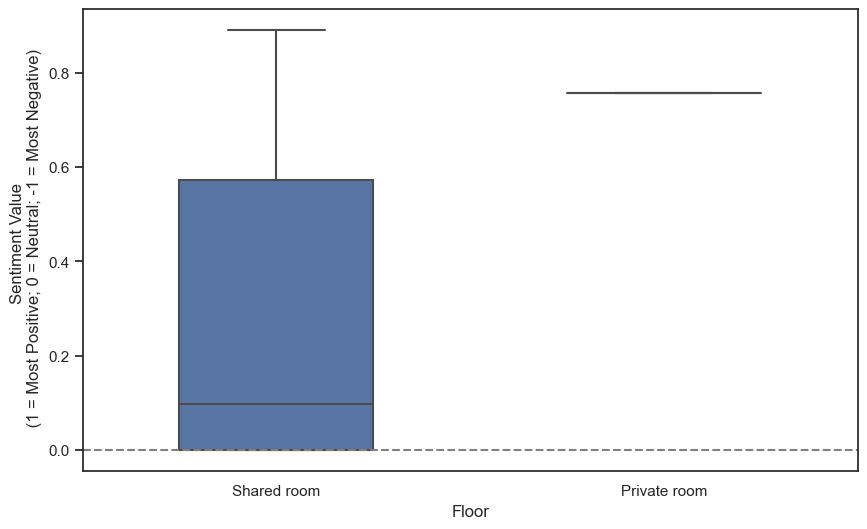

In [44]:
def plot_sentiment_analysis_spaces(df, label):
    f = plt.figure(figsize=(10, 6))
    sns.boxplot(x='space-type', y='compound', width=0.5,
 data=df)
    plt.xlabel("Floor")
    plt.ylabel("Sentiment Value \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.tick_params(bottom=False)
    plt.axhline(0, ls='--', c = 'grey')
    plt.savefig('plots/employees-' + label + '-space-wise-sentiment-distribution.jpg',
                dpi=300, bbox_inches='tight')
    
plot_sentiment_analysis_spaces(df_sent_emo, "emotion")

## Comfort:

In [124]:
df_sent_comfort = sentiment_analysis(df, 'comfort')

Most positive emotion statement:  ['5th Floor' 'Shared room' nan
 "I feel anxious a lot of the time but that is also because of my colleagues because I don't like them. I feel the surroundings seem clean but also cold."
 'THere is a lot of natural light, which is good. But also bright office lighting, a bit too much i think. I really do think the space could be furnished more cosy, like at ILLC (go check it out, they even have books and real kitchen towels)'
 {'neg': 0.136, 'neu': 0.749, 'pos': 0.116, 'compound': 0.0989}
 {'neg': 0.0, 'neu': 0.777, 'pos': 0.223, 'compound': 0.8812} 0.0 0.777
 0.223 0.8812 'positive']


Most negative emotion statement:  ['5th Floor' 'Shared room' nan
 "A mix of 'isolated',  'open', 'collaborative'"
 'Temperature was a bit low for my comfort earlier in the year. Now it was fine. I do wish I had a (automatic) height adjustable desk, and a waste basket in each office (but I understand the difficulty with the latter). I have very noisy neighbours who are lo

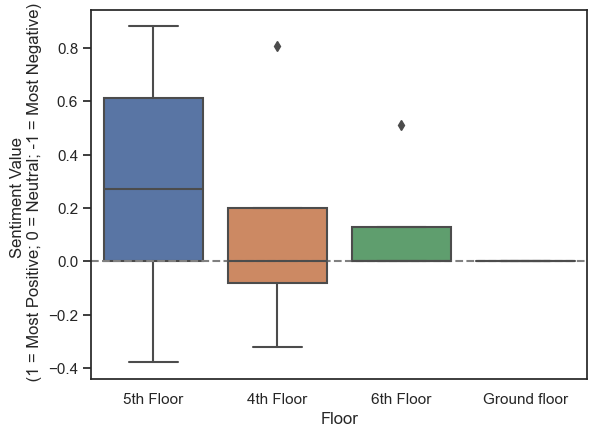

In [125]:
plot_sentiment_analysis(df_sent_comfort, 'comfort')

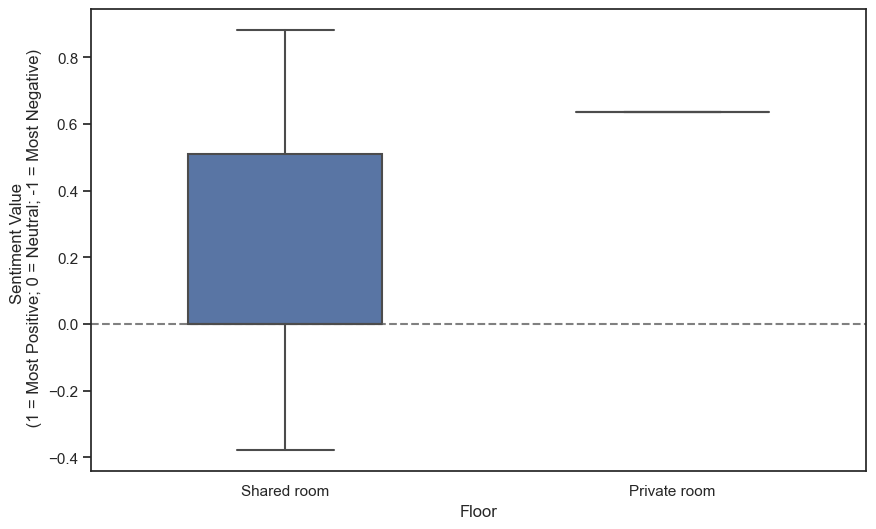

In [41]:
def plot_sentiment_analysis_spaces(df, label):
    f = plt.figure(figsize=(10, 6))
    sns.boxplot(x='space-type', y='compound', width=0.5,
 data=df)
    plt.xlabel("Floor")
    plt.ylabel("Sentiment Value \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.tick_params(bottom=False)
    plt.axhline(0, ls='--', c = 'grey')
    plt.savefig('plots/employees"-' + label + 'space-wise-sentiment-distribution.jpg',
                dpi=300, bbox_inches='tight')
    
plot_sentiment_analysis_spaces(df_sent_comfort, "comfort")

In [77]:
df_sent_comfort[df_sent_comfort['comfort'].str.contains("loud")==True]


,building,floor,space-type,emotion,comfort,emotion-polarity,comfort-polarity,neg,neu,pos,compound,comfort-sentiment
10,A,1st Floor,Group work tables,Comfortable and at ease mostly. It's a nice pl...,The noise level is okay for working in a group...,"{'neg': 0.0, 'neu': 0.449, 'pos': 0.551, 'comp...","{'neg': 0.1, 'neu': 0.857, 'pos': 0.043, 'comp...",0.1,0.857,0.043,-0.4497,negative
33,Unsure,Ground floor,Cafe,I would describe my feelings as laid back and ...,The cafe was because of the lunch quite loud w...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.907, 'pos': 0.093, 'comp...",0.0,0.907,0.093,0.5106,positive
46,A,1st Floor,Group work tables,"I’m studying with friends, feeling fine :)","I’m comfortable here, but it’s a bit too loud ...","{'neg': 0.0, 'neu': 0.242, 'pos': 0.758, 'comp...","{'neg': 0.0, 'neu': 0.823, 'pos': 0.177, 'comp...",0.0,0.823,0.177,0.2846,positive
47,A,1st Floor,Unsure,I feel slightly annoyed by the people talking ...,"Temperature and air are fine, noise is too lou...","{'neg': 0.133, 'neu': 0.867, 'pos': 0.0, 'comp...","{'neg': 0.0, 'neu': 0.87, 'pos': 0.13, 'compou...",0.0,0.870,0.130,0.2023,positive
63,A,1st Floor,Group work tables,Productive and happy,There is enough light and the air quality is f...,"{'neg': 0.0, 'neu': 0.351, 'pos': 0.649, 'comp...","{'neg': 0.0, 'neu': 0.94, 'pos': 0.06, 'compou...",0.0,0.940,0.060,0.1027,positive
64,Unsure,1st Floor,Unsure,"It’s loud and open, people work quietly while ...","Very much, temperature is good, loud noise due...","{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'comp...","{'neg': 0.0, 'neu': 0.812, 'pos': 0.188, 'comp...",0.0,0.812,0.188,0.7003,positive
96,A,Ground floor,Cafe,Chill but focussed,Quite comfortable now but occasionally loud an...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.753, 'pos': 0.247, 'comp...",0.0,0.753,0.247,0.3174,positive


In [73]:
for row in df_sent_comfort['comfort'][df_sent_comfort['comfort'].str.contains("comfortable")==True]:
    print(row, "\n")

I feel comfortable but watched 

The presence of sunlight gives a comfortable, alive feeling 

Temperature and light is good. A little noisy but it is in the central hall so that's to be expected. The wooden benches are not comfortable! 

The noise level is okay for working in a group, but if you wanted to study solo it would be too loud. The chairs are uncomfortable and could use a cushion or something.  

i’m feeling quite comfortable although the white sheets could use some nice soft seating 

Quite comfortable! There is some noise but I don't mind it personally at this moment. Theres some nice light coming from outside. The temperature is good.  

lot of noise, so a bit uncomfortable  

I'm very comfortable. Temperature is fine, I like the background noise of people chatting here, the lighting is okay, air quality is normal, chairs are comfortable  

I feel very comfortable, I don’t feel ant specific emotion, so also quite neutral, again. 

The temperature and light are comfortable